In [ ]:
 8from google.colab import drive
drive.mount('/content/drive')

!pip3 install --upgrade tensorflow==2.12.0
!pip install pyyaml h5py  # Required to save models in HDF5 format
!pip install pytorch
!pip install torch
!pip install torchversion
!pip install sklearn
!pip install --upgrade arabic-reshaper python-bidi pillow
!pip install -q gwpy


!pip install gTTS
!pip install playsound
!pip install pygobject
!pip install winsound
!pip install time
!pip install pyglet
!pip install simpleaudio

from google.colab import files
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import Image
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, save_model, load_model
import arabic_reshaper
from bidi.algorithm import get_display
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from scipy import ndimage

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 945.8 kB/s eta 0:00:00
     ━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7020 sha256=cfa670fff6e97b89ede5c43bec5aee53d64bc7d49efe8a6646f9e0e50fdc0205
  Stored in directory: /root/.cache/pip/wheels/90/89/ed/2d643f4226fc8c7c9156fc28abd8051e2d2c0de37ae51ac45c
Successfully built playsound
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.9/346.9 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × 

In [ ]:
characters=['d', 'N', 'o', 'O', 'J', 'L', 'r', 'i', 'h', 'n', 'p', 'c', 'y', 'D', 'e', 'k', 'v', 't', 'j', 'A', 'w', 'K', 's', 'P', 'u', 'm', 'q', 'x', 'E', 'B', 'g', 'l', 'f', 'z', 'b', 'a', '_']

# Batch size for training and validation
batch_size = 16

#
# Desired image dimensions
img_width = 200
img_height = 50



# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = 15

# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

class CTCLayer(layers.Layer):
    def __init__(self, name=None, **kwargs ):
        super().__init__(name=name, **kwargs)

        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)


        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

# Get the prediction model by extracting layers till the output layer
model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

#arabic dictionary
my_dict={'a' : 'ا' ,'b':'ب','c':'ت','d':'ث','e':'ج','f': 'ح' ,'g': 'د','h': 'ذ','i' : 'ر' ,
         'j': 'ز' ,'k': 'س','l': 'ش','m' : 'ص','n': 'ض','o': 'ط','p': 'ظ','q': 'ع',
         'r': 'غ' ,'s': 'ف','t' : 'ق','u': 'ك','v': 'ل','w': 'م','x': 'ن','y': 'ه' ,
         'z': 'و' ,'A': 'ي','B': 'ء' ,'C': 'إ','D': 'أ','E': 'إ','J': 'آ','K': 'ؤ' ,
         'L': 'ئ' ,'P':'خ','M': 'لا','N':'ة','_':' '}

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    ##convert label to arabic
    a=""
    #print(output_text[0])
    for c in output_text[0]:
         #print(c)
         if c=='[':
          break
         else:
          a=a+my_dict.get(c)
    a = arabic_reshaper.reshape(a)
    a = get_display(a)
    return a

# Desired image dimensions
img_width = 200
img_height = 50

# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

model=load_model('/content/drive/MyDrive/New/Arabic_Images_English_Labels_Traditional_Arabic_24.h5', custom_objects={'CTCLayer': CTCLayer})
print("Loaded model7 from disk")
# Get the prediction model by extracting layers till the output layer
model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output)
# A utility function to decode the output of the network

img_path='/content/drive/MyDrive/Arabic_Images_English_Labels_Traditional_Arabic_24/zwAn___________.png'

img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
img = tf.image.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
img = tf.image.convert_image_dtype(img,dtype=tf.float32,saturate=False)
    # 4. Resize to the desired size
img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
img = tf.transpose(img, perm=[1, 0, 2])

##add it to List
max_len = 1
dtype = tf.float32
samples = tf.TensorArray(dtype=dtype, size=max_len, clear_after_read=False)
for i in tf.range(max_len):
  sample = tf.cast(img, dtype=dtype)
  samples = samples.write(i, sample)

###get Results
preds = model.predict(samples.stack())
pred_texts = decode_batch_predictions(preds)
a = arabic_reshaper.reshape(pred_texts)
a = get_display(a)
print(a)




def predictThat(img_path):
  img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
  img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
  img = tf.image.convert_image_dtype(img,dtype=tf.float32,saturate=False)
    # 4. Resize to the desired size
  img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
  img = tf.transpose(img, perm=[1, 0, 2])

  max_len = 1
  dtype = tf.float32
  samples = tf.TensorArray(dtype=dtype, size=max_len, clear_after_read=False)
  for i in tf.range(max_len):
   sample = tf.cast(img, dtype=dtype)
   samples = samples.write(i, sample)

  preds = model.predict(samples.stack())
  preds
  pred_texts = decode_batch_predictions(preds)
  a = arabic_reshaper.reshape(pred_texts)
  a = get_display(a)
  return a

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


Loaded model7 from disk
1/1 [==============================] - 2s 2s/step
ﻭﻣﻴﺾ           


Saving wAuaxAuA_______.png to wAuaxAuA_______ (3).png


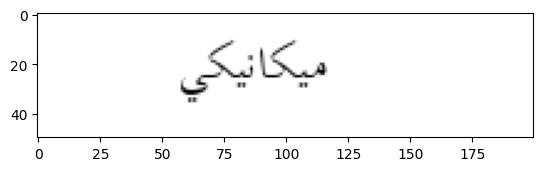

1/1 [==============================] - 0s 37ms/step


'ﻣﻴﻜﺎﻧﻴﻜﻲ       '

In [ ]:
uploaded = files.upload();
filename = next(iter(uploaded))
img = cv2.imread("//content//"+filename)
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()
predictThat(filename)


In [ ]:
from ipyfilechooser import FileChooser

starting_directory = '/content/drive/MyDrive/Arabic_Images_English_Labels_Traditional_Arabic_13'
chooser = FileChooser(starting_directory)
display(chooser)

print(chooser.selected_path)

FileChooser(path='/content/drive/MyDrive/Arabic_Images_English_Labels_Traditional_Arabic_13', filename='', tit…

None


In [ ]:
# @title Default title text


In [ ]:
from google.colab import files
import zipfile, io, os

def upload_dir_file(case_f):
    # author: yasser mustafa, 21 March 2018
    # case_f = 0 for uploading one File or Package(.py) and case_f = 1 for uploading one Zipped Directory
    uploaded = files.upload()    # to upload a Full Directory, please Zip it first (use WinZip)
    for fn in uploaded.keys():
        name = fn  #.encode('utf-8')
        #print('\nfile after encode', name)
        #name = io.BytesIO(uploaded[name])
    if case_f == 0:    # case of uploading 'One File only'
        print('\n file name: ', name)
        return name
    else:   # case of uploading a directory and its subdirectories and files
        zfile = zipfile.ZipFile(name, 'r')   # unzip the directory
        zfile.extractall()
        for d in zfile.namelist():   # d = directory
            print('\n main directory name: ', d)
            return d
print('Done!')

file_name = upload_dir_file(0)
dir_name = upload_dir_file(1)

Done!


KeyboardInterrupt: 